# Problema 9.9

<style type="text/css">
       ol{list-style-type: lower-alpha;}
</style>

Se obtiene experimentalmente la curva de reacción de un proceso y se obtienen los siguientes datos:

Tiempo (min) | Variable manipulable | Salida medida
-------------|-----------|-------
-2 | 100 | 200
-1 | 100 | 200
0 | 150 | 200.1
0.2 | 150 | 201.1
0.4 | 150 | 204.0
0.6 | 150 | 227.0
0.8 | 150 | 251.0
1.0 | 150 | 280.0
1.2 | 150 | 302.5
1.4 | 150 | 318.0
1.6 | 150 | 329.5
1.8 | 150 | 336.0
2.0 | 150 | 339.0
2.2 | 150 | 340.5
2.4 | 150 | 341.0

Usando esos valores:

1. Aproximar la respuesta de lazo abierto a un sistema de primer orden con retraso.

2. Seleccionar los parámetros de un controlador PI utilizando la técnica de Cohen-Coon.

---

**Solución**

Una de las primeras tareas cuando se dispone de datos experimentales es representarlos gráficamente:

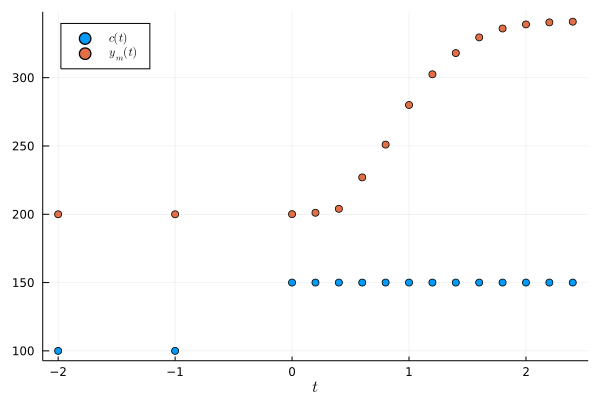

In [1]:
using Plots, LaTeXStrings

t = [-2.0, -1.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
c = [100, 100, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
ym = [200, 200, 200.1, 201.1, 204.0, 227.0, 251.0, 280.0, 302.5, 318.0, 329.5, 336.0, 339.0, 340.5, 341.0]

scatter(t, c, label=L"c(t)", legend=:topleft, xlabel=L"t")
scatter!(t, ym, label=L"y_m(t)")

Observamos que el cambio de la variable manipulable ($c(t)$) tiene forma de escalón y que la respuesta del proceso ($y_m(t)$) tiene un aspecto que parece ser compatible con la de un sistema de primer orden.

Para poder aplicar el método de la curva de reacción del proceso para poder identificar los parámetros del proceso equivalente de primer orden ($K$, $\tau$ y $t_d$) deberemos, en primer lugar, definir las variables de desviación. A partir del análisis del gráfico o de la tabla de datos que los valores en estado estacionario son:

$$\begin{aligned}
    c_e = 100\\
    y_{m,e} = 200
\end{aligned}$$

Por lo tanto las variables de desviación serán:

$$\begin{aligned}
    C(t) = c(t) - c_e = c(t) - 100\\
    Y_m = y_m(t) - y_{m,e} = y_m(t) - 200
\end{aligned}$$

Además solo consideraremos los puntos del 3 hasta el último, es decir, a partir del momento que se introduce el escalón:

In [2]:
tdata = t[3:end]
C = c[3:end] .- c[1]
Ym = ym[3:end] .- ym[1]

13-element Vector{Float64}:
   0.09999999999999432
   1.0999999999999943
   4.0
  27.0
  51.0
  80.0
 102.5
 118.0
 129.5
 136.0
 139.0
 140.5
 141.0

La representación gráfica de las variables de desviación queda como:

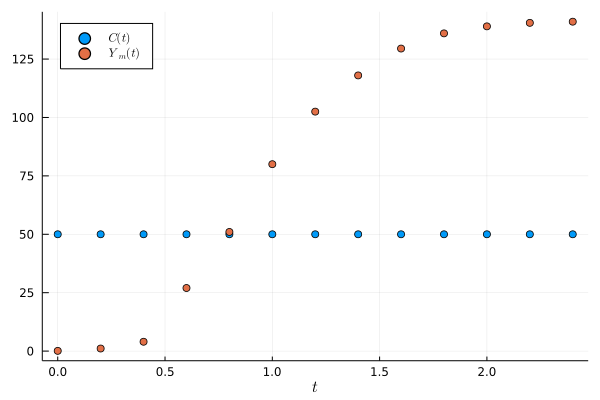

In [3]:
scatter(tdata, C, label=L"C(t)", legend=:topleft, xlabel=L"t")
scatter!(tdata, Ym, label=L"Y_m(t)")

En el gráfico se observa que la altura del escalón es:

In [4]:
A = C[1]

50

y como la respuesta en estado estacionario de la curva de reacción del proceso es:

In [5]:
B = Ym[end]

141.0

se puede encontrar fácilmente la ganancia de la curva de reacción del proceso:

In [6]:
K = B/A

2.82

Estimamos la posición del retraso en:

In [7]:
td = 0.45

0.45

Encontramos la el valor del retraso mediante interpolación lineal para el punto en el que $Y_m = B (1-1/\mathrm{e})$:

In [8]:
using Interpolations, Roots

itp = LinearInterpolation(tdata, Ym)
f(x)=itp(x)-B*(1-1/exp(1))

T = find_zero(f, 1)-td

0.6311466559540144

De manera que se obtienen los siguientes parámetros:

In [9]:
# Ganancia de Gcrp
K

2.82

In [10]:
# Constante de tiempo de Gcrp
round(T, digits=3)

0.631

In [11]:
# Retraso de Gcrp
td

0.45

Se puede comprobar la bondad del ajuste representando la curva de respuesta del proceso junto con los datos experimentales:

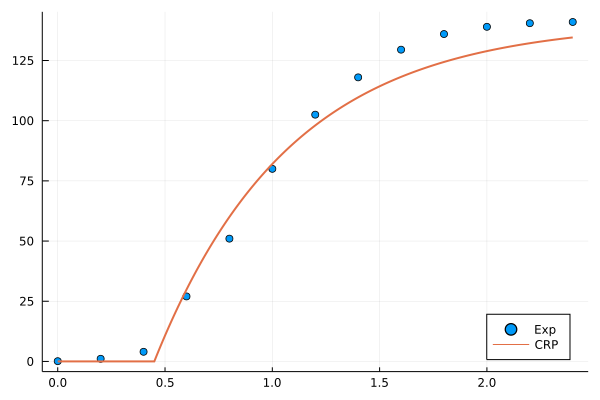

In [12]:
scatter(tdata, Ym, legend=:bottomright, label="Exp")
ysim(t, K, T, td) = K*A*(1-exp(-(t-td)/T))*(t-td>0)
tsim = tdata[1]:0.01:tdata[end]
plot!(tsim, ysim.(tsim, K, T, td), label="CRP", lw=2)

Se observa que el ajuste empeora a medida de que pasa el tiempo. Con toda probabilidad es debido a que el experimento ha finalizado demasiado pronto.

También podríamos haber obtenido los parámetros de $G_{CRP}$ mediante regresión no lineal utilizando la biblioteca `LsqFit`:

In [13]:
# using Pkg; Pkg.add("LsqFit")

using LsqFit

Definimos el modelo para el ajuste, que se corresponde con la respuesta de un sistema de primer orden con retraso para una entrada en escalón de magnitud $A$:

In [14]:
# p[1] es la ganancia
# p[2] es la constante de tiempo
# p[3] es el retraso

@. model(t, p) = p[1]*A*(1-exp(-(t-p[3])/p[2]))

model (generic function with 1 method)

Realizamos el ajuste no lneal:

In [15]:
fit = curve_fit(model, tdata, Ym, [1.0,1.0,1.0]; autodiff=:forwarddiff)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([4.802447963426727, 2.1466412022258297, 0.17044152652256872], [-19.9428481846808, 2.183738801583558, 20.352977611004334, 16.54789055998622, 10.035218244280557, -3.0331320342182124, -11.018766693162291, -13.295603685169993, -12.748777259949563, -8.273640159115786, -1.2748545760576349, 6.334436015708803, 14.133361359786875], [-4.131819508674528 9.615498099039767 -121.10325940192608; 0.683763536136367 -1.5192025261147952 -110.32987679737874; … ; 30.574914529825936 -41.08736145650451 -43.45764073609424; 32.302976011653314 -41.120922830672654 -39.591635865101814], true, Float64[])

Para facilitar el análisis, vamos a crear variables con los resultados del ajuste. Usaremos el subíndice `lsq` para indicar que son los valores obtenidos por regresión no lineal:

In [16]:
K_lsq = fit.param[1]
round(K_lsq, digits=3)

4.802

In [17]:
T_lsq = fit.param[2]
round(T_lsq, digits=3)

2.147

In [18]:
td_lsq = fit.param[3]
round(td_lsq, digits=3)

0.17

Al representar los dos modelos, podemos comprobar que el ajuste mediante regresión no lineal se ve todavía más afectado por la falta de datos a tiempos largos.

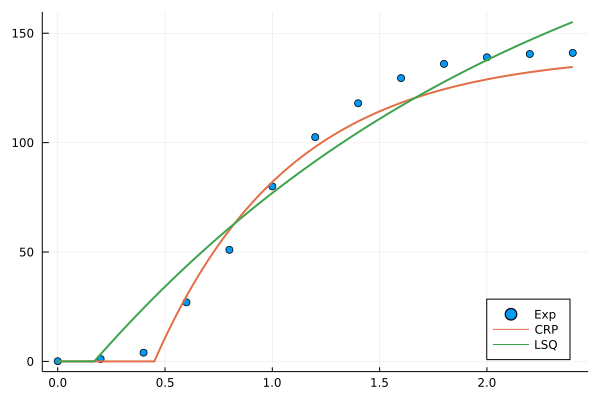

In [19]:
scatter(tdata, Ym, legend=:bottomright, label="Exp")
ysim(t, K, T, td) = K*A*(1-exp(-(t-td)/T))*(t-td>0)
plot!(tsim, ysim.(tsim, K, T, td), label="CRP", lw=2)
plot!(tsim, ysim.(tsim, K_lsq, T_lsq, td_lsq), label="LSQ", lw=2)

Quizás de manera sorprendente hemos encontrado que el ajuste utilizado por una técnica que podríamos considerar más rudimentaria nos porporciona un modelo experimental que tiene un comportamiento mejor que el proporcionado por un método más sofisticado y complejo, como es la regresión no lineal. La mayor sofisticación de la técnica no implica mejores resultados.

Calcular los parámetros del controlador PI resulta una tarea trivial:

In [20]:
Kc = 1/K*T/td*(0.9+td/12/T)
round(Kc, digits=3)

0.477

In [21]:
Ti = td*(30+3*td/T)/(9+20*td/T)
round(Ti, digits=3)

0.622